## Import and Utility

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import cv2
import shap
import glob
import torch
import numpy as np
from utils import *
from PIL import Image
from tqdm import tqdm
from lime import lime_image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from ScatNet_rgb import ScatNet2D
from torchvision import transforms
from CNN_128x128 import CNN_128x128
from kymatio.torch import Scattering2D
from torchvision import transforms as v2
from captum.attr import IntegratedGradients
from skimage.segmentation import mark_boundaries
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, SubsetRandomSampler

from tabulate import tabulate
device = "cuda" if torch.cuda.is_available() else "cpu"



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
def interpolate_images(baseline, image, alphas):
	alphas_x = alphas[:, None, None, None] # alpha values for x interpolation
	baseline_x = baseline.unsqueeze(0) 
	input_x = image.unsqueeze(0)
	delta = input_x - baseline_x
	images = baseline_x + alphas_x * delta
	return images

def plot_interpolated_images(interpolate_images, m_steps, step):
	alphas = torch.linspace(0, 1, steps=m_steps + 1)
	
	fig = plt.figure(figsize=(20, 20))
	for i in range(0, interpolate_images.size(1), step):
		plt.subplot(1, len(range(0, interpolate_images.size(1), step)), i // step + 1)
		image_np = interpolate_images[0, i].cpu().numpy().transpose(1, 2, 0)

		plt.imshow(image_np)
		plt.title(f"alpha: {alphas[i]:.1f}")
		plt.axis("off")
	plt.tight_layout()
	plt.show()

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((128, 128)),
        #transforms.CenterCrop(224)
    ])    
    return transf

def get_preprocess_transform(): 
    transf = transforms.Compose([
        transforms.ToTensor(),
    ])    
    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

def process_image(filename):
    img = Image.open(filename)
    img = img.resize((128, 128))
    return img

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(transforms.ToTensor()(i) for i in images), dim=0)
    batch = batch.to(device)
    logits = model(batch)
    return logits.detach().cpu().numpy()

## Load Model

In [3]:
scattering = Scattering2D(J=2, L=8, shape=(128,128)).to(device)
model = ScatNet2D(input_channels=81, scattering=scattering)

model.load_state_dict(torch.load(r'C:\Users\enric\Desktop\dataverse_files\glasses_or_no_glasses\model\rgb\ScatNet_model_dict_fold_1_trained_100epoch_validation_accuracy_0.8959390862944162_momentum0.0_.pt')) 
# for parameter in model.parameters():
#         parameter.requires_grad = False
model = model.to(device)
model.eval() 

ScatNet2D(
  (scattering): Scattering2D()
  (classifier): Sequential(
    (0): Linear(in_features=248832, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=2, bias=True)
  )
)

## Create baseline and load/ preprocess images

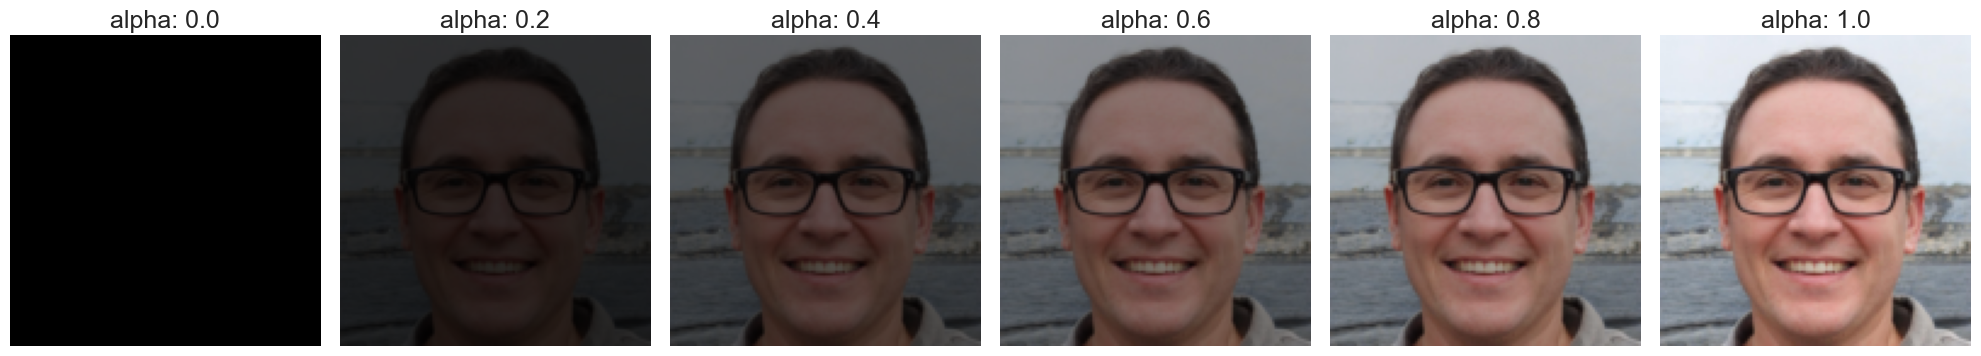

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


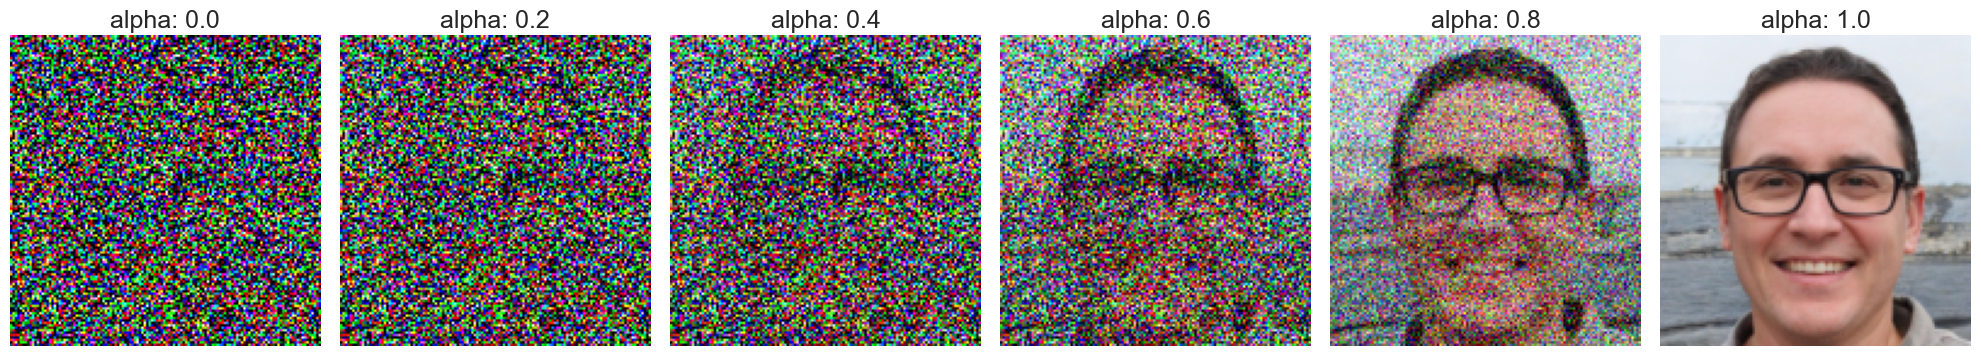

In [4]:
# Create baseline all to zero and random
baseline_zero = torch.zeros(1,3,128,128).to(device)
baseline_rand = torch.randn(1,3,128,128).to(device)

# Alpha values
step= 50
alpha = torch.linspace(0, 1, steps = step +1).to(device)

# Load images
image= Image.open(r'archive_488\Images\Images\glasses\face-80.jpg').convert('RGB')
image_noglasses= Image.open(r'archive_488\Images\Images\no_glasses\face-1533.jpg').convert('RGB')
image_sun_glasses = Image.open(r'archive_488\Images\Images\glasses\face-17.jpg').convert('RGB')



# Preprocess images (resize and tensorize)
preprocess_t = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Preprocess images (resize)
preprocess = transforms.Compose([
    transforms.Resize((128, 128)), 
])

# Tensorize images
input_image_tensor = preprocess_t(image).to(device)
input_image_tensor_noglasses = preprocess_t(image_noglasses).to(device)
input_image_tensor_sun_glasses = preprocess_t(image_sun_glasses).to(device)

# Resizing images
input_image = preprocess(image)
input_image_noglasses = preprocess(image_noglasses)
input_image_sun_glasses = preprocess(image_sun_glasses)

# Plot imgaes with baseline zero
interpolate = interpolate_images(baseline_zero,input_image_tensor,alpha)
plot_interpolated_images(interpolate,step,10)

# Plot imgaes with baseline random
interpolate = interpolate_images(baseline_rand,input_image_tensor,alpha)
plot_interpolated_images(interpolate,step,10)


## Integrated gradient from scratch

In [5]:
def compute_gradients(interpolated_images, model, target_class_idx):
	gradients = []
	model.eval()
	model.to(device)
	images = interpolated_images.clone().detach().requires_grad_(True).squeeze(0).to(device)
	output = model(images.to(device))
	probs = output[:, target_class_idx]
	gradients = torch.autograd.grad(probs, images, 
								grad_outputs=torch.ones_like(probs),
							 	create_graph=True)[0]
	return gradients

  
def integral_approximation(gradients):
	grads = (gradients[:-1] + gradients[1:]) / torch.Tensor([2.0]).to(device)
	# avg_grads = torch.mean(grads, dim=0)
	avg_grads = torch.mean(grads.detach(), axis=0)
	return avg_grads


def one_batch(baseline, image, alpha_batch, target_class_idx, model):
	interpolated_path_input_batch = interpolate_images(baseline=baseline, 
													   image=image, 
													   alphas=alpha_batch)
	gradients = compute_gradients(interpolated_images=interpolated_path_input_batch,
								  target_class_idx=target_class_idx,
								  model=model)
	return gradients


def integrated_gradients(baseline, image, target_class_idx, model, m_steps, batch_size):
	alphas = torch.linspace(start=0.0, end=1.0, steps=m_steps + 1).to(device)
	gradient_batches = []

	# Iterate alphas range and batch computation
	for alpha in tqdm(range(0, len(alphas), batch_size)):
		from_ = alpha
		to = min(from_ + batch_size, len(alphas))
		alpha_batch = alphas[from_:to]

		gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx, model)
		gradient_batches.append(gradient_batch)

	# Concatenate path gradients together row-wise into a single tensor.
	total_gradients = torch.cat(gradient_batches, dim=0)
	del gradient_batch
	del gradient_batches
	del alphas
	avg_gradients = integral_approximation(gradients=total_gradients)
	integrated_gradients = (image - baseline) * avg_gradients

	return integrated_gradients


In [6]:
def transform_ig(ig):
    ig = torch.sum(torch.abs(ig),dim=1)
    ig = (ig - torch.min(ig)) / (torch.max(ig) - torch.min(ig))
    ig = np.transpose(ig.detach().cpu().numpy(), (1, 2, 0))
    return ig

100%|██████████| 51/51 [00:09<00:00,  5.38it/s]


(-0.5, 127.5, 127.5, -0.5)

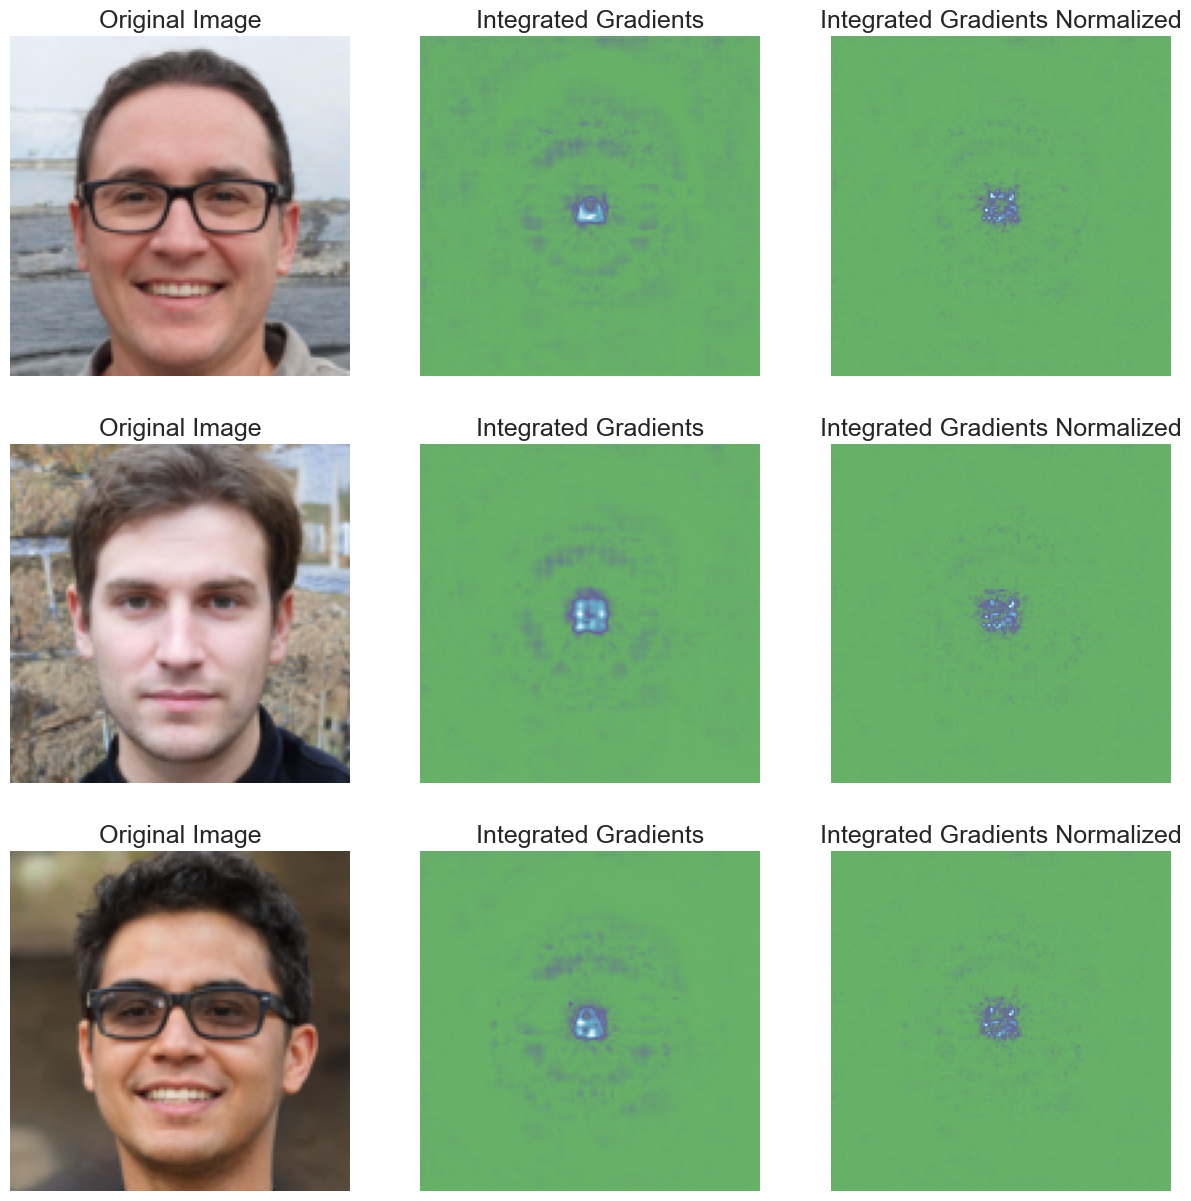

In [7]:
# Compute integrated gradients for glasses
ig_base = integrated_gradients(baseline_zero, input_image_tensor, 1, model, step,1)
ig_base = transform_ig(ig_base)
ig_norm = integrated_gradients(baseline_rand, input_image_tensor, 1, model, step,1)
ig_norm = transform_ig(ig_norm)

# Compute integrated gradients for no glasses
ig_base_noglasses = integrated_gradients(baseline_zero, input_image_tensor_noglasses, 1, model, step,1)
ig_base_noglasses = transform_ig(ig_base_noglasses)
ig_norm_noglasses = integrated_gradients(baseline_rand, input_image_tensor_noglasses, 1, model, step,1)
ig_norm_noglasses = transform_ig(ig_norm_noglasses)

# Compute integrated gradients for sun glasses
ig_base_sun_glasses = integrated_gradients(baseline_zero, input_image_tensor_sun_glasses, 1, model, step,1)
ig_base_sun_glasses = transform_ig(ig_base_sun_glasses)
ig_norm_sun_glasses = integrated_gradients(baseline_rand, input_image_tensor_sun_glasses, 1, model, step,1)
ig_norm_sun_glasses = transform_ig(ig_norm_sun_glasses)

# Plot images
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax[0,0].imshow(input_image)
ax[0,0].set_title('Original Image')
ax[0,0].axis('off')
ax[0,1].imshow(ig_base,cmap='ocean',alpha=0.6)
ax[0,1].set_title('Integrated Gradients')
ax[0,1].axis('off')
ax[0,2].imshow(ig_norm,cmap='ocean',alpha=0.6)
ax[0,2].set_title('Integrated Gradients Normalized')
ax[0,2].axis('off')

ax[1,0].imshow(input_image_noglasses)
ax[1,0].set_title('Original Image')
ax[1,0].axis('off')
ax[1,1].imshow(ig_base_noglasses,cmap='ocean',alpha=0.6)
ax[1,1].set_title('Integrated Gradients')
ax[1,1].axis('off')
ax[1,2].imshow(ig_norm_noglasses,cmap='ocean',alpha=0.6)
ax[1,2].set_title('Integrated Gradients Normalized')
ax[1,2].axis('off')

ax[2,0].imshow(input_image_sun_glasses)
ax[2,0].set_title('Original Image')
ax[2,0].axis('off')
ax[2,1].imshow(ig_base_sun_glasses,cmap='ocean',alpha=0.6)
ax[2,1].set_title('Integrated Gradients')
ax[2,1].axis('off')
ax[2,2].imshow(ig_norm_sun_glasses,cmap='ocean',alpha=0.6)
ax[2,2].set_title('Integrated Gradients Normalized')
ax[2,2].axis('off')

## Integrated gradient with Captum

(-0.5, 127.5, 127.5, -0.5)

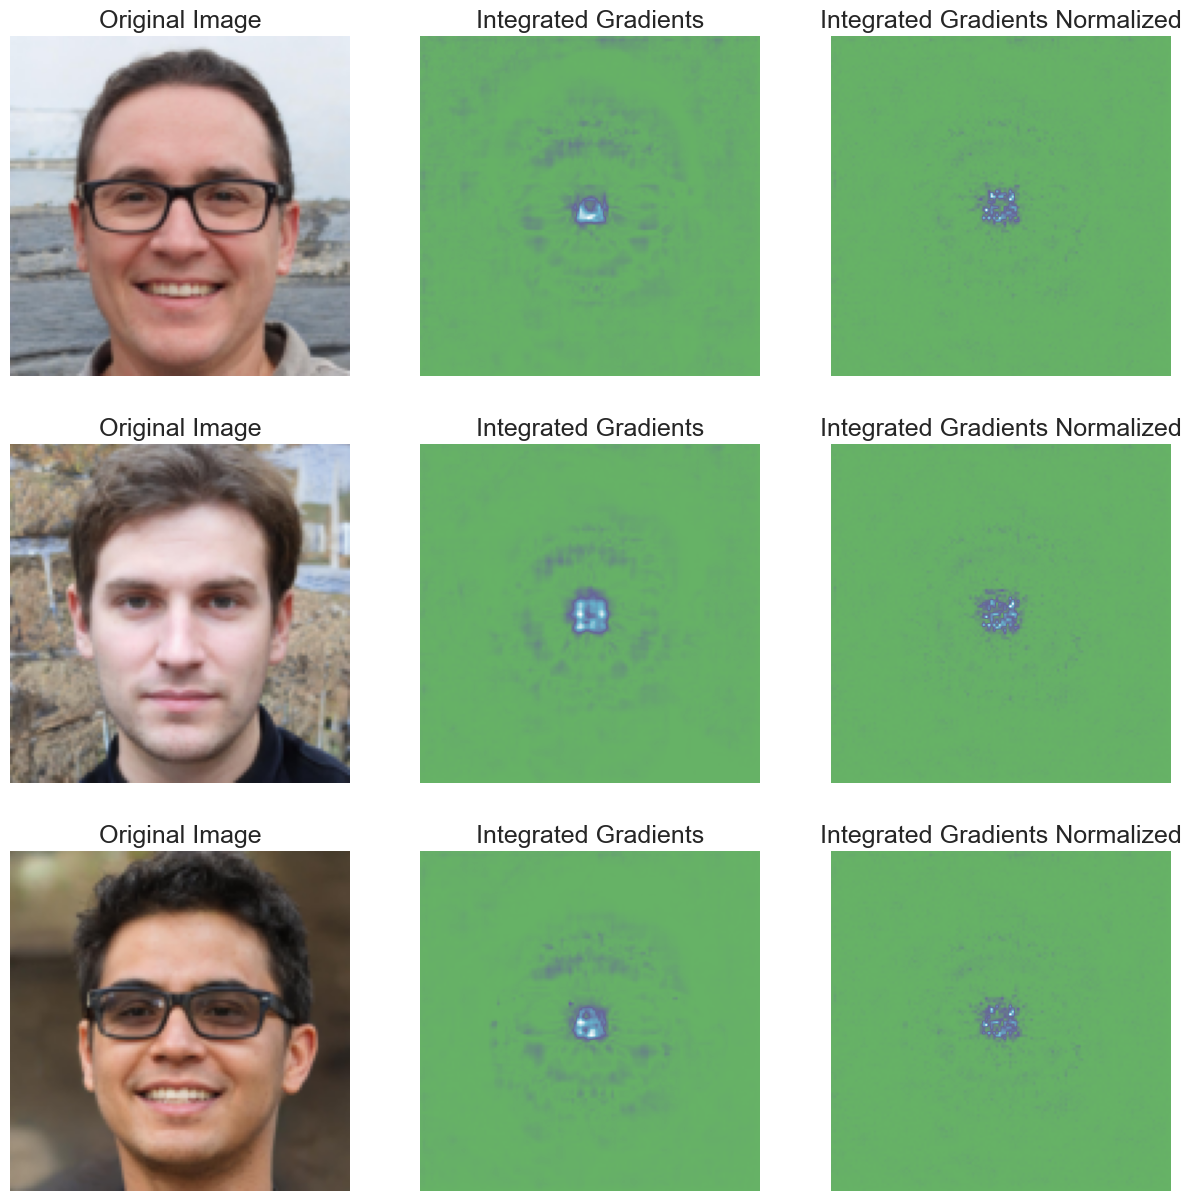

In [8]:
# Integrated gradients with captum
integrated_grads = IntegratedGradients(model)

# Compute integrated gradients for glasses
ig_captum = integrated_grads.attribute(input_image_tensor, target=0, baselines=baseline_zero, n_steps=step)
ig_captum= transform_ig(ig_captum).squeeze()
ig_captum_norm = integrated_grads.attribute(input_image_tensor, target=0, baselines=baseline_rand, n_steps=step)
ig_captum_norm= transform_ig(ig_captum_norm).squeeze()

# Compute integrated gradients for no glasses
ig_captum_noglasses = integrated_grads.attribute(input_image_tensor_noglasses, target=0, baselines=baseline_zero, n_steps=step)
ig_captum_noglasses= transform_ig(ig_captum_noglasses).squeeze()
ig_captum_norm_noglasses = integrated_grads.attribute(input_image_tensor_noglasses, target=0, baselines=baseline_rand, n_steps=step)
ig_captum_norm_noglasses= transform_ig(ig_captum_norm_noglasses).squeeze()

# Compute integrated gradients for sun glasses
ig_captum_sun_glasses = integrated_grads.attribute(input_image_tensor_sun_glasses, target=0, baselines=baseline_zero, n_steps=step)
ig_captum_sun_glasses=  transform_ig(ig_captum_sun_glasses).squeeze()
ig_captum_norm_sun_glasses = integrated_grads.attribute(input_image_tensor_sun_glasses, target=0, baselines=baseline_rand, n_steps=step)
ig_captum_norm_sun_glasses= transform_ig(ig_captum_norm_sun_glasses).squeeze()

# Plot images
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax[0,0].imshow(input_image)
ax[0,0].set_title('Original Image')
ax[0,0].axis('off')
ax[0,1].imshow(ig_captum,cmap='ocean',alpha=0.6)
ax[0,1].set_title('Integrated Gradients')
ax[0,1].axis('off')
ax[0,2].imshow(ig_captum_norm,cmap='ocean',alpha=0.6)
ax[0,2].set_title('Integrated Gradients Normalized')
ax[0,2].axis('off')

ax[1,0].imshow(input_image_noglasses)
ax[1,0].set_title('Original Image')
ax[1,0].axis('off')
ax[1,1].imshow(ig_captum_noglasses,cmap='ocean',alpha=0.6)
ax[1,1].set_title('Integrated Gradients')
ax[1,1].axis('off')
ax[1,2].imshow(ig_captum_norm_noglasses,cmap='ocean',alpha=0.6)
ax[1,2].set_title('Integrated Gradients Normalized')
ax[1,2].axis('off')

ax[2,0].imshow(input_image_sun_glasses)
ax[2,0].set_title('Original Image')
ax[2,0].axis('off')
ax[2,1].imshow(ig_captum_sun_glasses,cmap='ocean',alpha=0.6)
ax[2,1].set_title('Integrated Gradients')
ax[2,1].axis('off')
ax[2,2].imshow(ig_captum_norm_sun_glasses,cmap='ocean',alpha=0.6)
ax[2,2].set_title('Integrated Gradients Normalized')
ax[2,2].axis('off')


## LIME

In [9]:
# Initiate explainer instance for lime
explainer = lime_image.LimeImageExplainer()

# Explain glasses
explanation = explainer.explain_instance(np.array(pill_transf(input_image)),
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0,
                                         num_samples=1000) # number of images that will be sent to classification function

# Explain no glasses
explanation_noglasses = explainer.explain_instance(np.array(pill_transf(input_image_noglasses)),
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0,
                                         num_samples=1000) # number of images that will be sent to classification function

# Explain sun glasses
explanation_sun_glasses = explainer.explain_instance(np.array(pill_transf(image_sun_glasses)),
                                            batch_predict, # classification function
                                            top_labels=1, 
                                            hide_color=0,
                                            num_samples=1000) # number of images that will be sent to classification function

100%|██████████| 1000/1000 [02:49<00:00,  5.91it/s]


### Positive only set to True

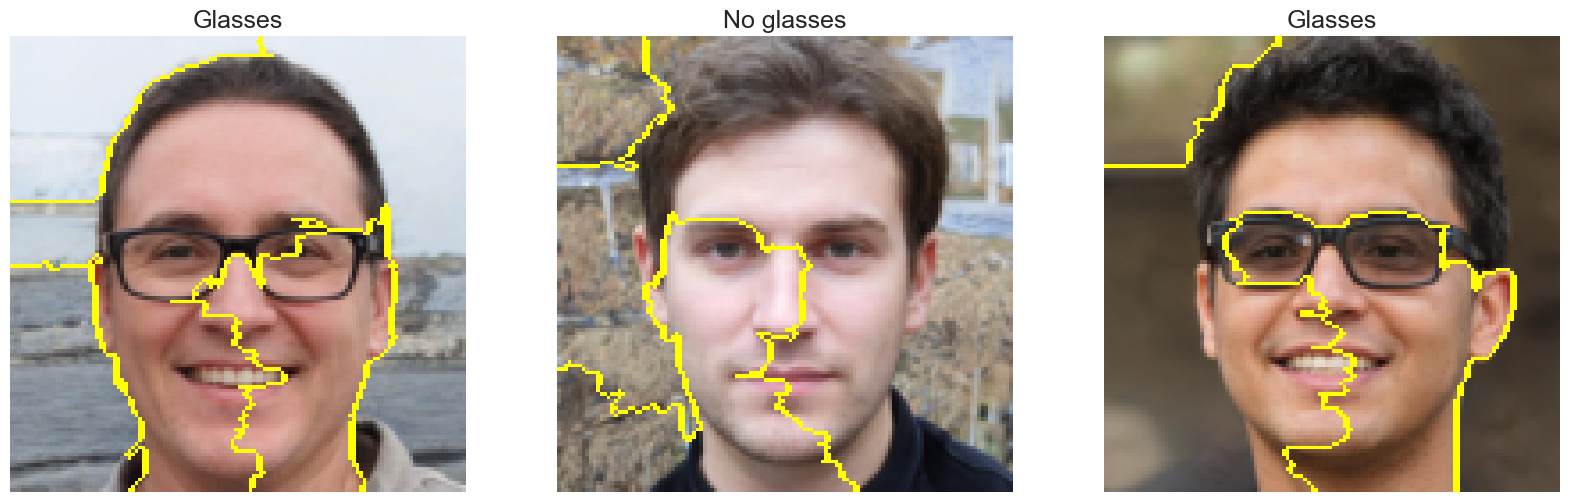

In [10]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=7, hide_rest=False)
img_boundry1_glasses = mark_boundaries(temp/255.0, mask)

temp, mask = explanation_noglasses.get_image_and_mask(explanation_noglasses.top_labels[0], positive_only=True, num_features=7, hide_rest=False)
img_boundry1_noglasses = mark_boundaries(temp/255.0, mask)

temp, mask = explanation_sun_glasses.get_image_and_mask(explanation_sun_glasses.top_labels[0], positive_only=True, num_features=15, hide_rest=False)
img_boundry1_sun_glasses = mark_boundaries(temp/255.0, mask)

# Plot images
fig, ax = plt.subplots(1,3, figsize=(20,20))

ax[0].imshow(img_boundry1_glasses)
ax[0].set_title('Glasses')
ax[0].axis('off')

ax[1].imshow(img_boundry1_noglasses)
ax[1].set_title('No glasses')
ax[1].axis('off')

ax[2].imshow(img_boundry1_sun_glasses)
ax[2].set_title('Glasses')
ax[2].axis('off')

plt.show()


### Positive only set to False

(-0.5, 127.5, 127.5, -0.5)

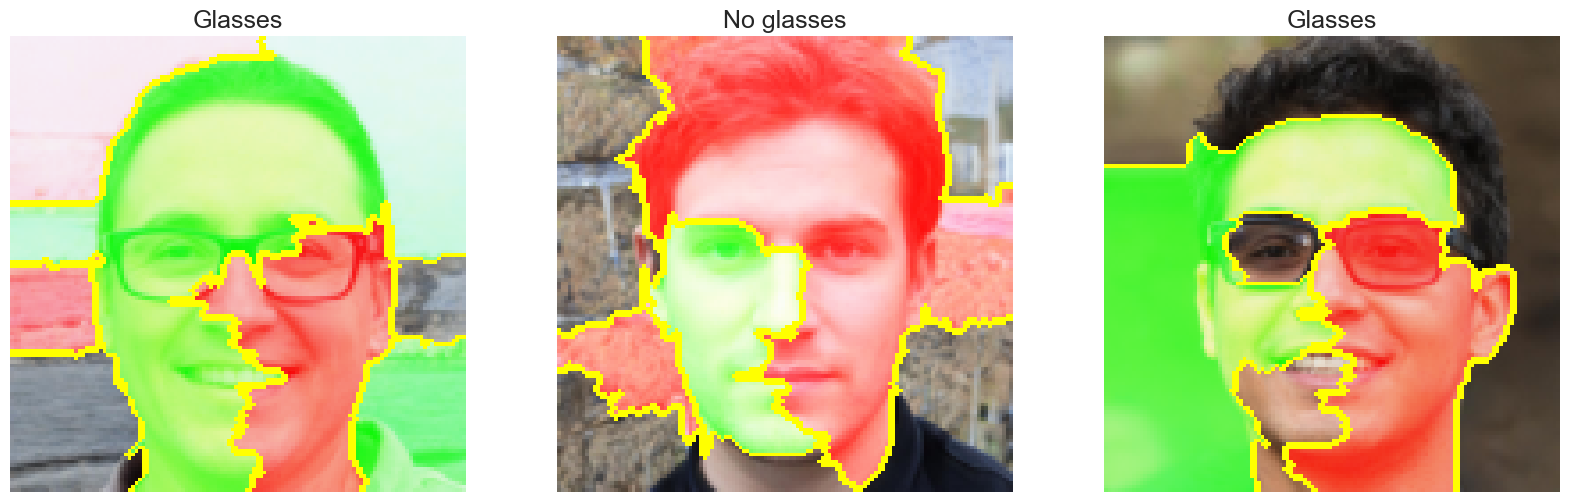

In [11]:
temp_glasses, mask_glasses = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=8, hide_rest=False)
img_boundry2_glasses = mark_boundaries(temp_glasses/255.0, mask_glasses)


temp_no_glasses, mask_no_glasses = explanation_noglasses.get_image_and_mask(explanation_noglasses.top_labels[0], positive_only=False, num_features=7, hide_rest=False)
img_boundry2_noglasses = mark_boundaries(temp_no_glasses/255.0, mask_no_glasses)


temp_sun_glasses, mask_sun_glasses = explanation_sun_glasses.get_image_and_mask(explanation_sun_glasses.top_labels[0], positive_only=False , num_features=4, hide_rest=False)
img_boundry2_sun_glasses = mark_boundaries(temp_sun_glasses/255.0, mask_sun_glasses)


fig, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(img_boundry2_glasses)
ax[0].set_title('Glasses' if explanation.top_labels[0] == 1 else 'No glasses')
ax[0].axis('off')
ax[1].imshow(img_boundry2_noglasses)
ax[1].set_title('Glasses' if explanation_noglasses.top_labels[0] == 1 else 'No glasses')
ax[1].axis('off')
ax[2].imshow(img_boundry2_sun_glasses)
ax[2].set_title('Glasses' if explanation_sun_glasses.top_labels[0] == 1 else 'No glasses')
ax[2].axis('off')



## SHAP

In [12]:
labels, images = [], []
model.eval()

test_aug = v2.Compose([
    v2.ToTensor(),
])

train_aug = v2.Compose([
    v2.ToTensor(),
    v2.RandomRotation(degrees=180),
    v2.RandomHorizontalFlip(p=1),
    v2.RandomVerticalFlip(p=1),
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.4),
])

open_path = 'archive_488/Images/Images/glasses/'
with ThreadPoolExecutor() as executor:
    filenames = glob.glob(open_path + '*.jpg')
    for img in tqdm(executor.map(process_image, filenames), total=len(filenames)):
        images.append(img)
        labels.append(1)

open_path = 'archive_488/Images/Images/no_glasses/'
with ThreadPoolExecutor() as executor:
    filenames = glob.glob(open_path + '*.jpg')
    for img in tqdm(executor.map(process_image, filenames), total=len(filenames)):
        images.append(img)
        labels.append(0)


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42)

del images, labels

X_train = [train_aug(img) for img in tqdm(X_train)]
X_test = [test_aug(img) for img in tqdm(X_test)]

train_data = CustomDataset(np.array(X_train), y_train)
shap_loader = DataLoader(train_data, batch_size=16, shuffle=True)
background,_ = next(iter(shap_loader))
background = background.to(device)




100%|██████████| 984/984 [00:00<00:00, 3543.34it/s]


In [13]:
e = shap.DeepExplainer(model, background[0:500])

#X_test_stack = torch.stack(X_test).to(device)

shap_values_glasses = e.shap_values(input_image_tensor.unsqueeze(0),check_additivity=False)
shap_values_noglasses = e.shap_values(input_image_tensor_noglasses.unsqueeze(0),check_additivity=False)
shap_values_sun_glasses = e.shap_values(input_image_tensor_sun_glasses.unsqueeze(0),check_additivity=False)


unrecognized nn.Module: Scattering2D


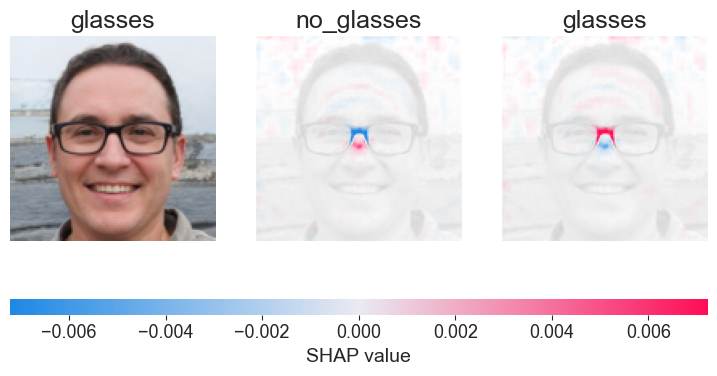

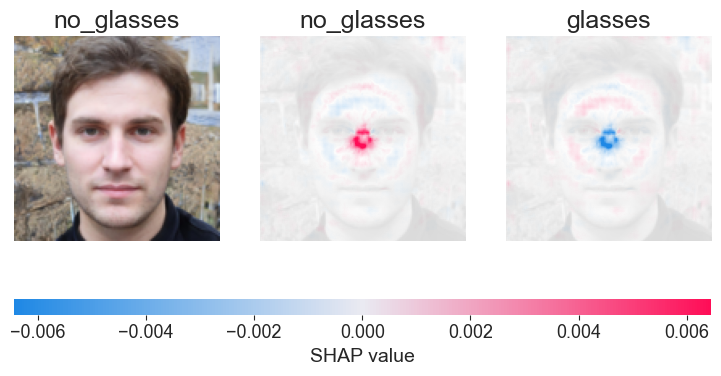

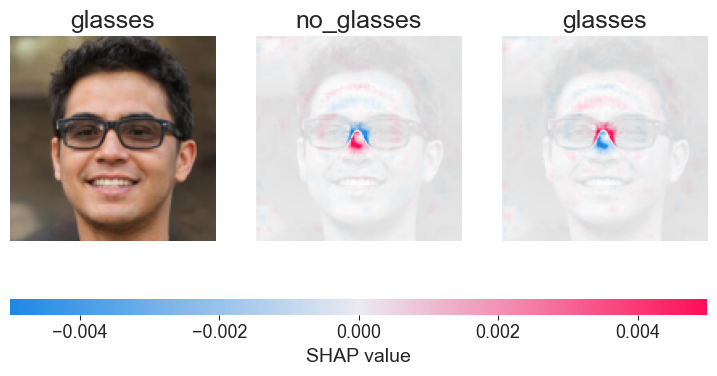

In [14]:

shap_numpy_glasses = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values_glasses]
shap_numpy_no_glasses = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values_noglasses]
shap_numpy_sun_glasses = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values_sun_glasses]
test_numpy_glasses = np.swapaxes(np.swapaxes( np.array(input_image_tensor.detach().cpu().unsqueeze(0)), 1, -1), 1, 2)
test_numpy_no_glasses = np.swapaxes(np.swapaxes( np.array(input_image_tensor_noglasses.detach().cpu().unsqueeze(0)), 1, -1), 1, 2)
test_numpy_sun_glasses = np.swapaxes(np.swapaxes( np.array(input_image_tensor_sun_glasses.detach().cpu().unsqueeze(0)), 1, -1), 1, 2)

shap.image_plot(shap_numpy_glasses, test_numpy_glasses,show=False, true_labels=['glasses'],labels=['no_glasses','glasses'])
shap.image_plot(shap_numpy_no_glasses, test_numpy_no_glasses,show=False, true_labels=['no_glasses'],labels=['no_glasses','glasses'])
shap.image_plot(shap_numpy_sun_glasses, test_numpy_sun_glasses,show=False, true_labels=['glasses'],labels=['no_glasses','glasses'])


### Comparison with Integrated gradient with Captum and SHAP

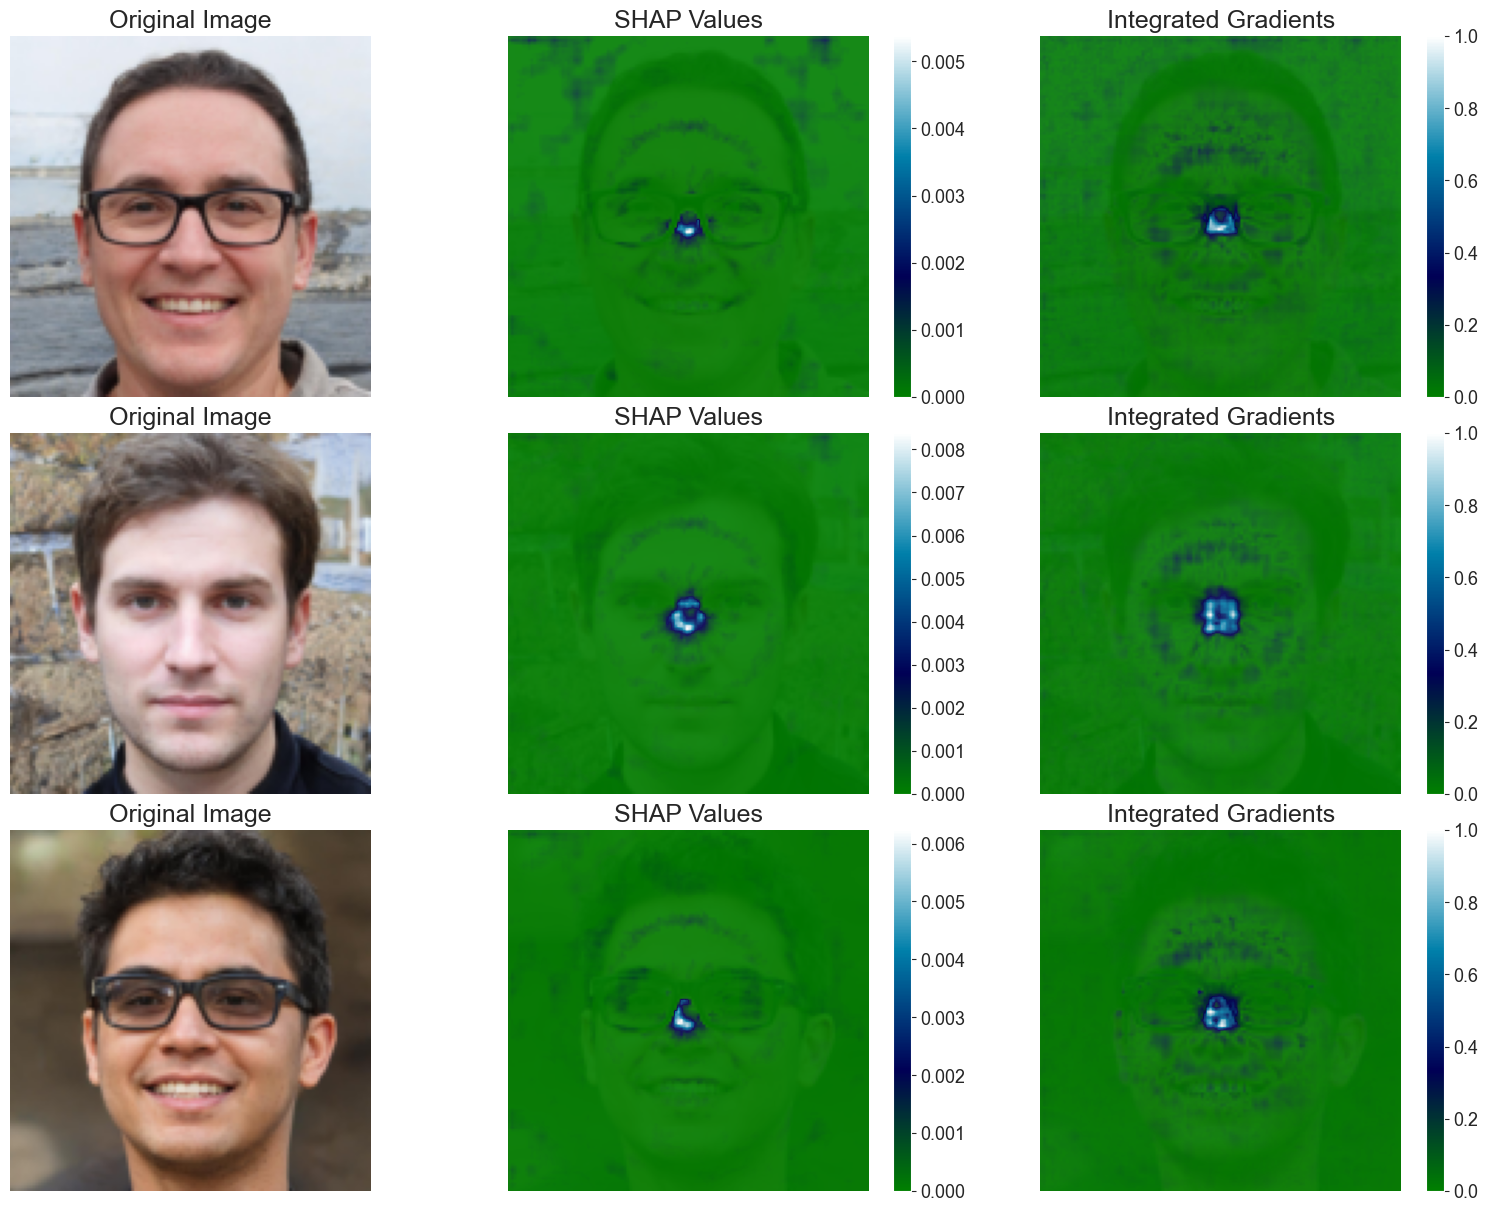

In [15]:

# Get the sum along the last axis
summed_values_glasses = shap_values_glasses[0][0].transpose(1, 2, 0).sum(-1)
summed_values_glasses[summed_values_glasses < 0] = 0
# Create the imshow plot
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
ax[0][0].imshow(input_image)
ax[0][0].set_title('Original Image')
ax[0][0].axis('off')
ax[0][1].set_title('SHAP Values')
ax[0][1].axis('off')
plt.colorbar(ax[0][1].imshow(summed_values_glasses, cmap='ocean'),orientation='vertical')
ax[0][1].imshow(input_image, alpha=0.1)
ax[0][2].set_title('Integrated Gradients')
ax[0][2].axis('off')
plt.colorbar(ax[0][2].imshow(ig_captum,cmap='ocean'), orientation='vertical')
ax[0][2].imshow(input_image, alpha=0.1)

summed_values_noglasses = shap_values_noglasses[0][0].transpose(1, 2, 0).sum(-1)
summed_values_noglasses[summed_values_noglasses < 0] = 0
ax[1][0].imshow(input_image_noglasses)
ax[1][0].set_title('Original Image')
ax[1][0].axis('off')
ax[1][1].set_title('SHAP Values')
ax[1][1].axis('off')
plt.colorbar(ax[1][1].imshow(summed_values_noglasses, cmap='ocean'), orientation='vertical')
ax[1][1].imshow(input_image_noglasses, alpha=0.1)
ax[1][2].set_title('Integrated Gradients')
ax[1][2].axis('off')
plt.colorbar(ax[1][2].imshow(ig_captum_noglasses,cmap='ocean'), orientation='vertical')
ax[1][2].imshow(input_image_noglasses, alpha=0.1)

summed_values_sun_glasses = shap_values_sun_glasses[0][0].transpose(1, 2, 0).sum(-1)
summed_values_sun_glasses[summed_values_sun_glasses < 0] = 0
ax[2][0].imshow(input_image_sun_glasses)
ax[2][0].set_title('Original Image')
ax[2][0].axis('off')
ax[2][1].set_title('SHAP Values')
ax[2][1].axis('off')
plt.colorbar(ax[2][1].imshow(summed_values_sun_glasses, cmap='ocean'), orientation='vertical')
ax[2][1].imshow(input_image_sun_glasses, alpha=0.1)
ax[2][2].set_title('Integrated Gradients')
ax[2][2].axis('off')
plt.colorbar(ax[2][2].imshow(ig_captum_sun_glasses,cmap='ocean'), orientation='vertical')
ax[2][2].imshow(input_image_sun_glasses, alpha=0.1)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


## Statistical Analysis

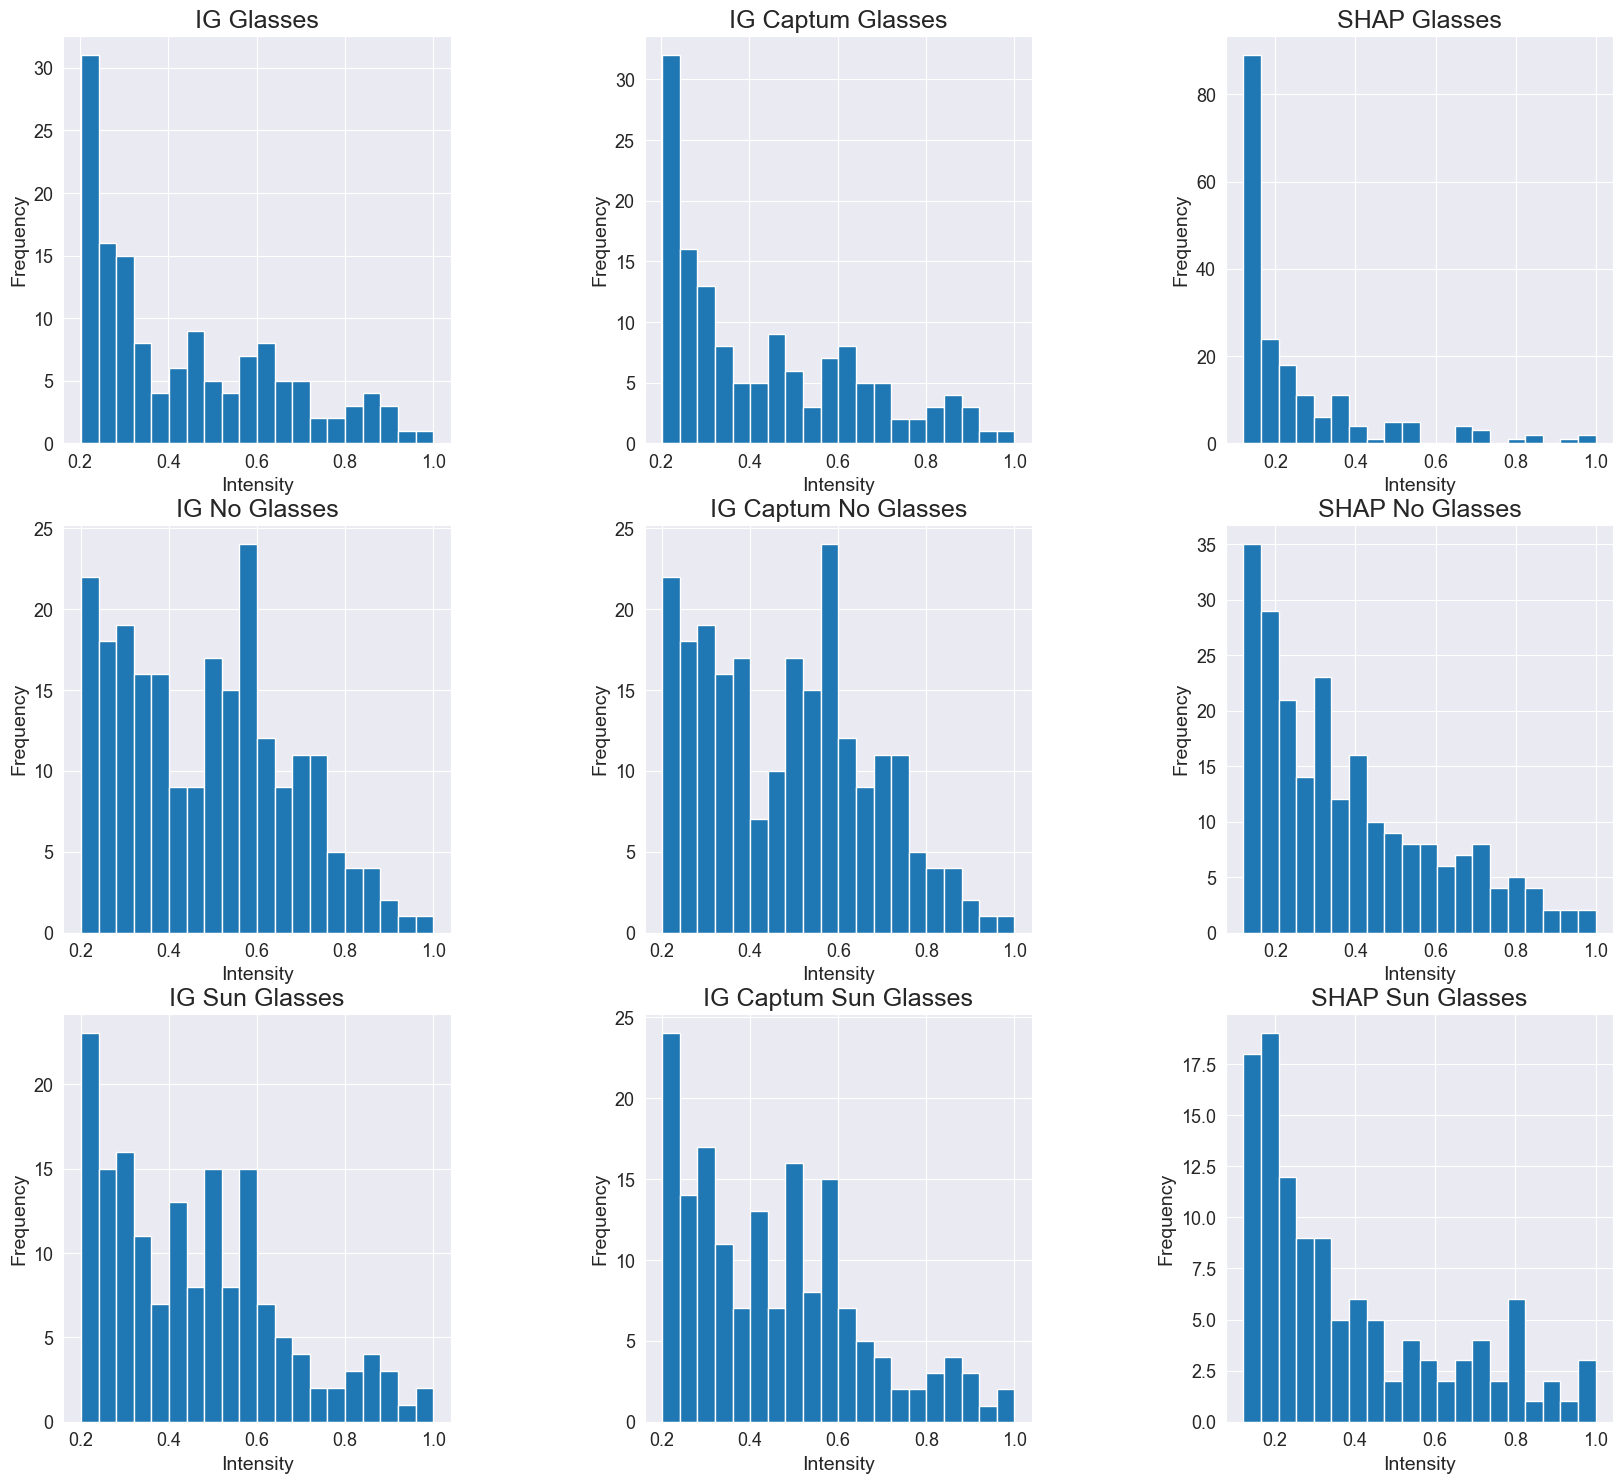

In [16]:
# Normalize the summed values
summed_values_transform = (summed_values_glasses - np.min(summed_values_glasses)) / (np.max(summed_values_glasses) - np.min(summed_values_glasses))

# Plot the histograms
fig, axs = plt.subplots(3, 3, figsize=(20, 18), gridspec_kw = {'wspace':0.5, 'hspace':0.2})

#glasses
grads_c = np.where(ig_base >= 0.2)
grads_c_captum = np.where(ig_captum >= 0.2)
summed_values_norm_glasses = (summed_values_glasses - np.min(summed_values_glasses)) / (np.max(summed_values_glasses) - np.min(summed_values_glasses))
shap_c = np.where(summed_values_transform >= 0.12)

ig_c_zero_baseline_new = ig_base[grads_c]
ig_c_zero_baseline_captum_new = ig_captum[grads_c_captum]
new_summed_values = summed_values_norm_glasses[shap_c]

#no glasses
grads_c_noglasses = np.where(ig_base_noglasses >= 0.2)
grads_c_captum_noglasses = np.where(ig_captum_noglasses >= 0.2)
summed_values_norm_noglasses = (summed_values_noglasses - np.min(summed_values_noglasses)) / (np.max(summed_values_noglasses) - np.min(summed_values_noglasses))
shap_c_noglasses = np.where(summed_values_norm_noglasses >= 0.12)


ig_c_zero_baseline_new_noglasses = ig_base_noglasses[grads_c_noglasses]
ig_c_zero_baseline_captum_new_noglasses = ig_captum_noglasses[grads_c_captum_noglasses]
new_summed_values_noglasses = summed_values_norm_noglasses[shap_c_noglasses]

#sun glasses
grads_c_sun_glasses = np.where(ig_base_sun_glasses >= 0.2)
grads_c_captum_sun_glasses = np.where(ig_captum_sun_glasses >= 0.2)
summed_values_norm_sun_glasses = (summed_values_sun_glasses - np.min(summed_values_sun_glasses)) / (np.max(summed_values_sun_glasses) - np.min(summed_values_sun_glasses))
shap_c_sun_glasses = np.where(summed_values_norm_sun_glasses >= 0.12)

ig_c_zero_baseline_new_sun_glasses = ig_base_sun_glasses[grads_c_sun_glasses]
ig_c_zero_baseline_captum_new_sun_glasses = ig_captum_sun_glasses[grads_c_captum_sun_glasses]
new_summed_values_sun_glasses = summed_values_norm_sun_glasses[shap_c_sun_glasses]


axs[0][0].hist(ig_c_zero_baseline_new.flatten(), bins=20)
axs[0][0].set_title('IG Glasses')
axs[0][0].set_xlabel('Intensity')
axs[0][0].set_ylabel('Frequency')
axs[0][1].hist(ig_c_zero_baseline_captum_new.flatten(), bins=20)
axs[0][1].set_title('IG Captum Glasses')
axs[0][1].set_xlabel('Intensity')
axs[0][1].set_ylabel('Frequency')

axs[1][0].hist(ig_c_zero_baseline_new_noglasses.flatten(), bins=20)
axs[1][0].set_title('IG No Glasses')
axs[1][0].set_xlabel('Intensity')
axs[1][0].set_ylabel('Frequency')
axs[1][1].hist(ig_c_zero_baseline_captum_new_noglasses.flatten(), bins=20)
axs[1][1].set_title('IG Captum No Glasses')
axs[1][1].set_xlabel('Intensity')
axs[1][1].set_ylabel('Frequency')

axs[2][0].hist(ig_c_zero_baseline_new_sun_glasses.flatten(), bins=20)
axs[2][0].set_title('IG Sun Glasses')
axs[2][0].set_xlabel('Intensity')
axs[2][0].set_ylabel('Frequency')
axs[2][1].hist(ig_c_zero_baseline_captum_new_sun_glasses.flatten(), bins=20)
axs[2][1].set_title('IG Captum Sun Glasses')
axs[2][1].set_xlabel('Intensity')
axs[2][1].set_ylabel('Frequency')

axs[0][2].hist(new_summed_values.flatten(), bins=20)
axs[0][2].set_title('SHAP Glasses')
axs[0][2].set_xlabel('Intensity')
axs[0][2].set_ylabel('Frequency')
axs[1][2].hist(new_summed_values_noglasses.flatten(), bins=20)
axs[1][2].set_title('SHAP No Glasses')
axs[1][2].set_xlabel('Intensity')
axs[1][2].set_ylabel('Frequency')
axs[2][2].hist(new_summed_values_sun_glasses.flatten(), bins=20)
axs[2][2].set_title('SHAP Sun Glasses')
axs[2][2].set_xlabel('Intensity')
axs[2][2].set_ylabel('Frequency')

plt.show()








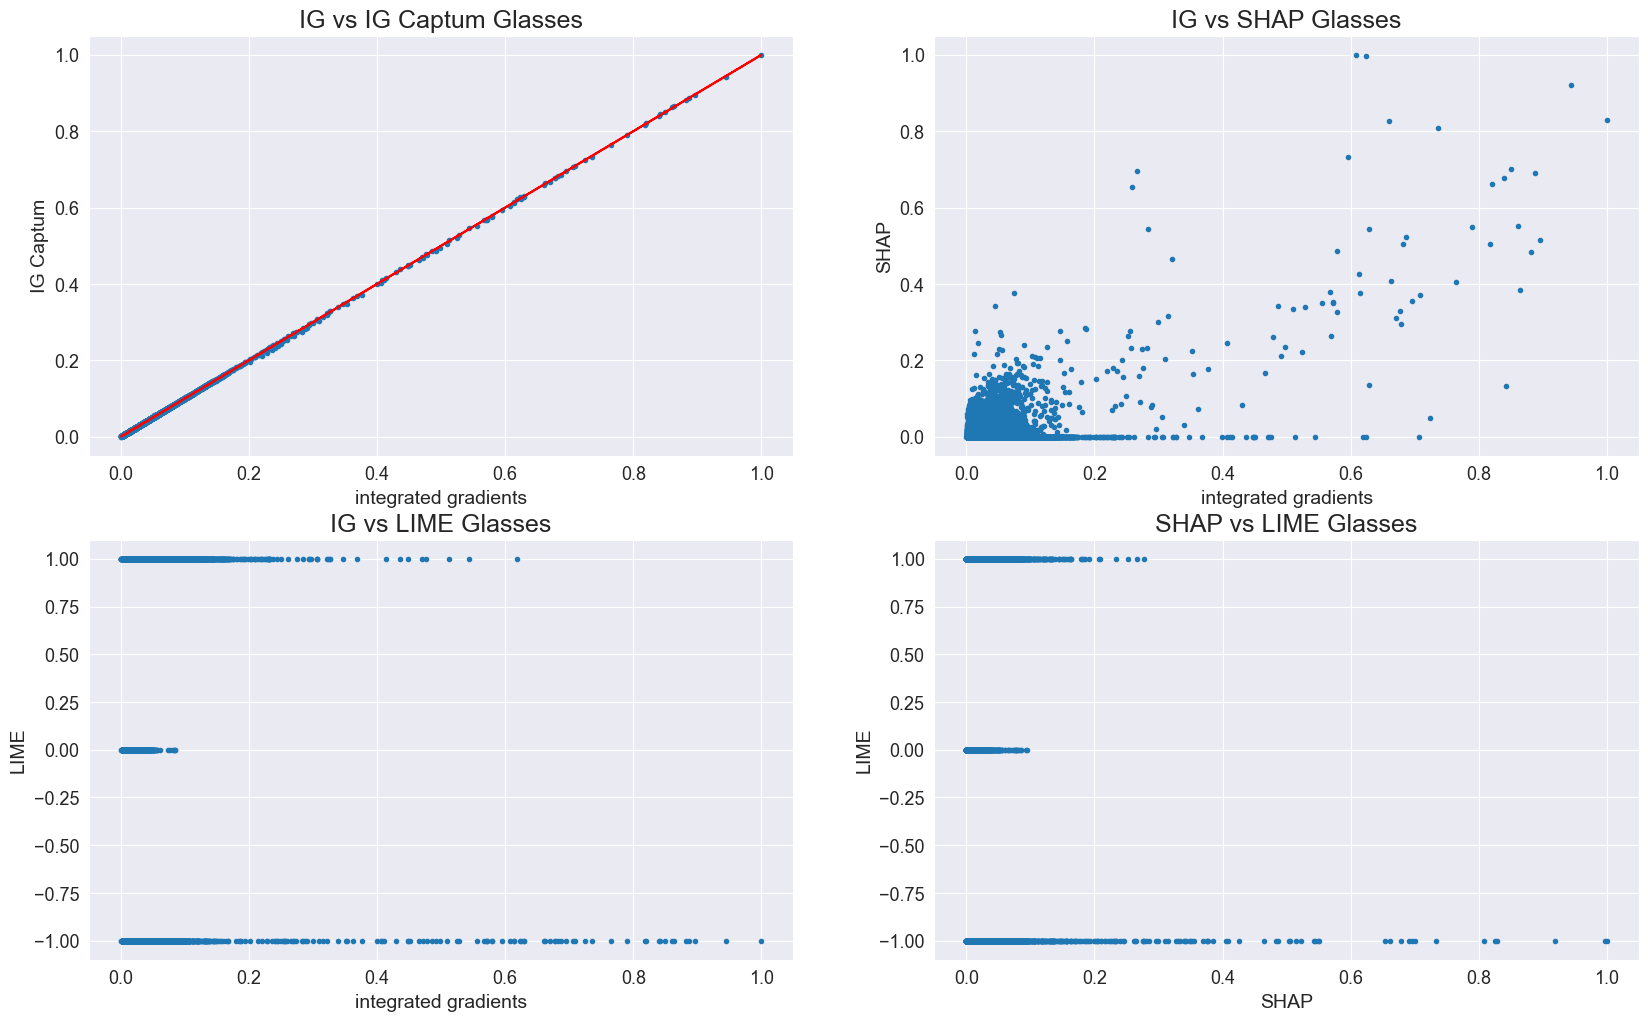

In [17]:
fig, ax = plt.subplots(2,2, figsize=(20,12))
ax[0][0].plot(ig_base.flatten(),ig_captum.flatten(), '.')
ax[0][0].set_xlabel('integrated gradients')
ax[0][0].set_ylabel('IG Captum')
ax[0][0].set_title('IG vs IG Captum Glasses')
m, b = np.polyfit(ig_base.flatten(), ig_captum.flatten(), 1)
ax[0][0].plot(ig_base.flatten(), m*ig_base.flatten() + b, color='red')
ax[0][0].grid(True)

ax[0][1].plot(ig_base.flatten(), summed_values_norm_glasses.flatten(), '.')
ax[0][1].set_xlabel('integrated gradients')
ax[0][1].set_ylabel('SHAP')
ax[0][1].set_title('IG vs SHAP Glasses')
ax[0][1].grid(True)

ax[1][0].plot(ig_base.flatten(), mask_glasses.flatten(), '.') 
ax[1][0].set_xlabel('integrated gradients')
ax[1][0].set_ylabel('LIME')
ax[1][0].set_title('IG vs LIME Glasses')
ax[1][0].grid(True)

ax[1][1].plot(summed_values_norm_glasses.flatten(), mask_glasses.flatten(), '.')
ax[1][1].set_xlabel('SHAP')
ax[1][1].set_ylabel('LIME')
ax[1][1].set_title('SHAP vs LIME Glasses')
ax[1][1].grid(True)

In [18]:

#calculate baricenters
bc_a=np.mean(ig_c_zero_baseline_new.flatten(), axis=0)
bc_b=np.mean(ig_c_zero_baseline_captum_new.flatten(), axis=0)
bc_c=np.mean(new_summed_values.flatten(), axis=0)
bc_d=np.mean(mask_glasses.flatten(), axis=0)

#calculate the spread of the distributions, e.g. their standard deviation
spread_a=np.std(ig_base.flatten())
spread_b=np.std(ig_captum.flatten())
spread_c=np.std(summed_values_glasses.flatten())
spread_d=np.std(mask_glasses.flatten())


#calculate the distance between baricenters
dist_a_b=np.linalg.norm(bc_a-bc_b)
dist_a_c=np.linalg.norm(bc_a-bc_c)
dist_a_d=np.linalg.norm(bc_a-bc_d)
dist_c_d=np.linalg.norm(bc_c-bc_d)

#calculate the distance between the spreads
dist_spread_a_b=np.abs(spread_a-spread_b)
dist_spread_a_c=np.abs(spread_a-spread_c)
dist_spread_a_d=np.abs(spread_a-spread_d)
dist_spread_c_d=np.abs(spread_c-spread_d)

#display the results
table_data = [
    ["ig to ig_captum", dist_a_b, dist_spread_a_b],
    ["ig to SHAP", dist_a_c, dist_spread_a_c],
    ["ig to LIME", dist_a_d, dist_spread_a_d],
    ["SHAP to LIME", dist_c_d, dist_spread_c_d]
]

table_headers = ["Comparison", "Distance between baricenters", "Distance between the spreads"]

table = tabulate(table_data, headers=table_headers, tablefmt="grid")
print("Glasses")
print(table)


Glasses
+-----------------+--------------------------------+--------------------------------+
| Comparison      |   Distance between baricenters |   Distance between the spreads |
+=================+================================+================================+
| ig to ig_captum |                    0.000800579 |                    9.31656e-06 |
+-----------------+--------------------------------+--------------------------------+
| ig to SHAP      |                    0.181166    |                    0.0486867   |
+-----------------+--------------------------------+--------------------------------+
| ig to LIME      |                    0.179407    |                    0.857501    |
+-----------------+--------------------------------+--------------------------------+
| SHAP to LIME    |                    0.00175928  |                    0.906188    |
+-----------------+--------------------------------+--------------------------------+


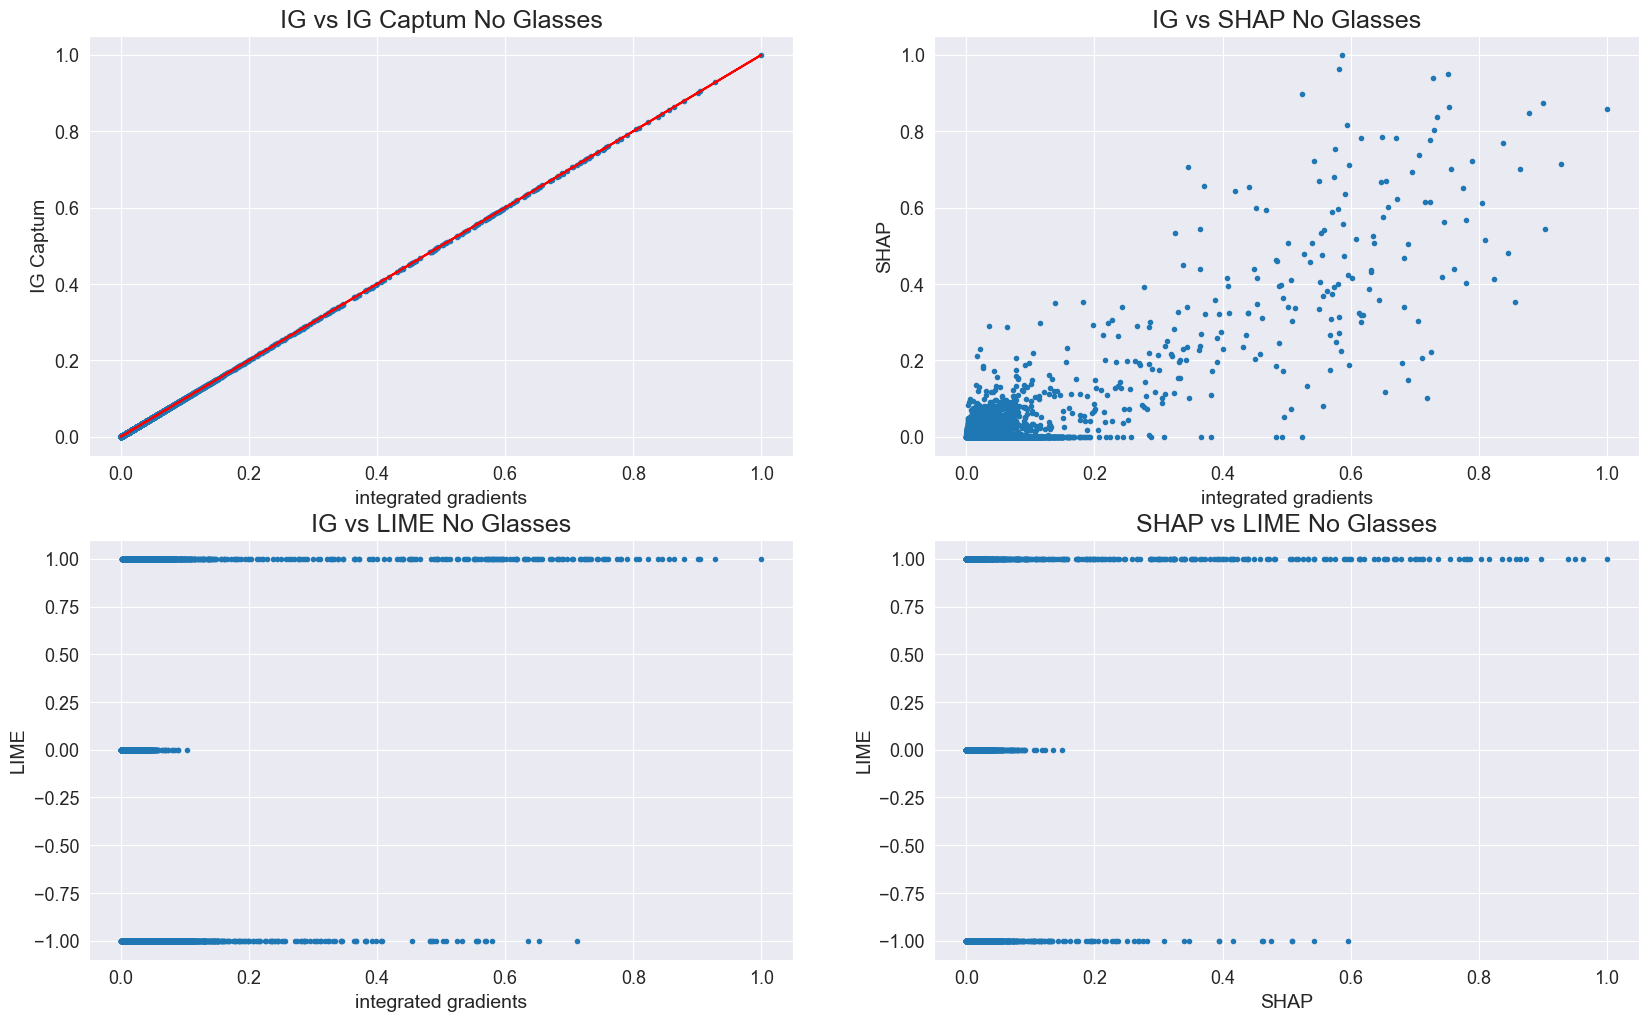

In [19]:
fig, ax = plt.subplots(2,2, figsize=(20,12))
ax[0][0].plot(ig_base_noglasses.flatten(), ig_captum_noglasses.flatten(), '.')
ax[0][0].set_xlabel('integrated gradients')
ax[0][0].set_ylabel('IG Captum')
ax[0][0].set_title('IG vs IG Captum No Glasses')
m, b = np.polyfit(ig_base_noglasses.flatten(), ig_captum_noglasses.flatten(), 1)
ax[0][0].plot(ig_base_noglasses.flatten(), m*ig_base_noglasses.flatten() + b, color='red')
ax[0][0].grid(True)

ax[0][1].plot(ig_base_noglasses.flatten(), summed_values_norm_noglasses.flatten(), '.')
ax[0][1].set_xlabel('integrated gradients')
ax[0][1].set_ylabel('SHAP')
ax[0][1].set_title('IG vs SHAP No Glasses')
ax[0][1].grid(True)

ax[1][0].plot(ig_base_noglasses.flatten(), mask_no_glasses.flatten(), '.') 
ax[1][0].set_xlabel('integrated gradients')
ax[1][0].set_ylabel('LIME')
ax[1][0].set_title('IG vs LIME No Glasses')
ax[1][0].grid(True)

ax[1][1].plot(summed_values_norm_noglasses.flatten(), mask_no_glasses.flatten(), '.')
ax[1][1].set_xlabel('SHAP')
ax[1][1].set_ylabel('LIME')
ax[1][1].set_title('SHAP vs LIME No Glasses')
ax[1][1].grid(True)

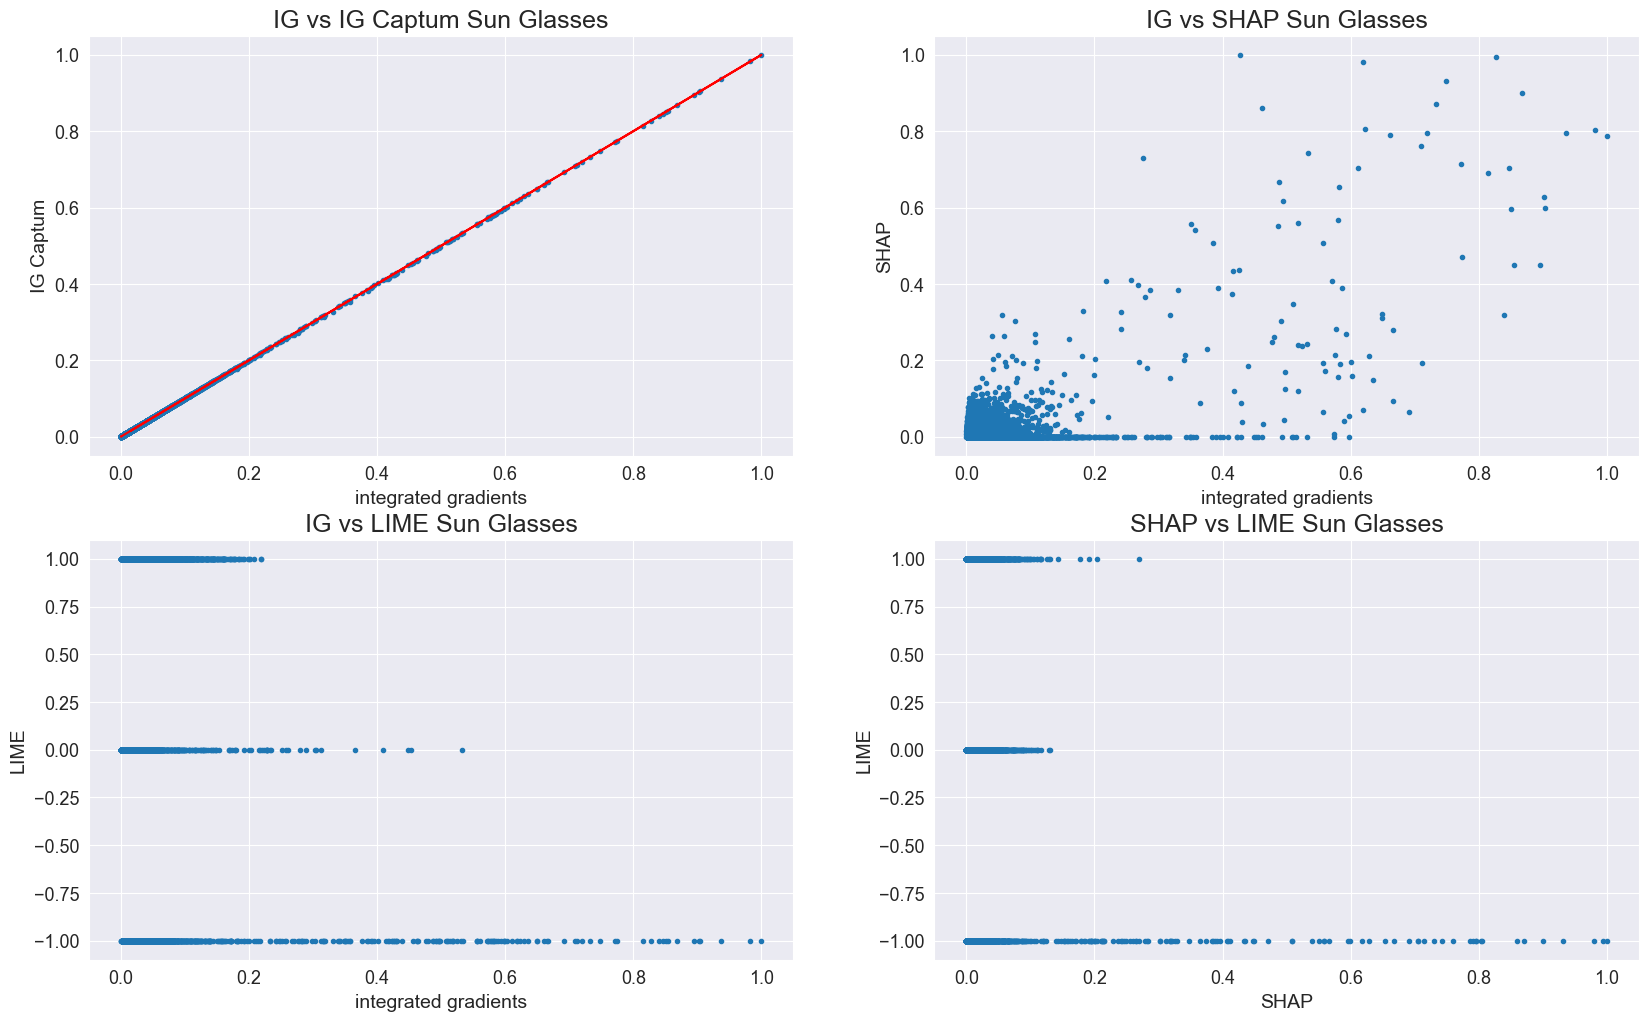

In [20]:
fig, ax = plt.subplots(2,2, figsize=(20,12))
ax[0][0].plot(ig_base_sun_glasses.flatten(), ig_captum_sun_glasses.flatten(), '.')
ax[0][0].set_xlabel('integrated gradients')
ax[0][0].set_ylabel('IG Captum')
ax[0][0].set_title('IG vs IG Captum Sun Glasses')
m, b = np.polyfit(ig_base_sun_glasses.flatten(), ig_captum_sun_glasses.flatten(), 1)
ax[0][0].plot(ig_base_sun_glasses.flatten(), m*ig_base_sun_glasses.flatten() + b, color='red')
ax[0][0].grid(True)

ax[0][1].plot(ig_base_sun_glasses.flatten(), summed_values_norm_sun_glasses.flatten(), '.')
ax[0][1].set_xlabel('integrated gradients')
ax[0][1].set_ylabel('SHAP')
ax[0][1].set_title('IG vs SHAP Sun Glasses')
ax[0][1].grid(True)

ax[1][0].plot(ig_base_sun_glasses.flatten(), mask_sun_glasses.flatten(), '.') 
ax[1][0].set_xlabel('integrated gradients')
ax[1][0].set_ylabel('LIME')
ax[1][0].set_title('IG vs LIME Sun Glasses')
ax[1][0].grid(True)

ax[1][1].plot(summed_values_norm_sun_glasses.flatten(), mask_sun_glasses.flatten(), '.')
ax[1][1].set_xlabel('SHAP')
ax[1][1].set_ylabel('LIME')
ax[1][1].set_title('SHAP vs LIME Sun Glasses')
ax[1][1].grid(True)

In [21]:
from tabulate import tabulate
table_data = [
    ["Glasses", np.corrcoef(ig_base.ravel(), ig_captum.ravel())[0, 1], np.corrcoef(ig_base.ravel(), summed_values_norm_glasses.ravel())[0, 1], np.corrcoef(ig_base.ravel(), mask_glasses.ravel())[0, 1], np.corrcoef(summed_values_norm_glasses.ravel(), mask_glasses.ravel())[0, 1]],
    ["No Glasses", np.corrcoef(ig_base_noglasses.ravel(), ig_captum_noglasses.ravel())[0, 1], np.corrcoef(ig_base_noglasses.ravel(), summed_values_norm_noglasses.ravel())[0, 1], np.corrcoef(ig_base_noglasses.ravel(), mask_no_glasses.ravel())[0, 1], np.corrcoef(summed_values_norm_noglasses.ravel(), mask_no_glasses.ravel())[0, 1]],
    ["Sun Glasses", np.corrcoef(ig_base_sun_glasses.ravel(), ig_captum_sun_glasses.ravel())[0, 1], np.corrcoef(ig_base_sun_glasses.ravel(), summed_values_norm_sun_glasses.ravel())[0, 1], np.corrcoef(ig_base_sun_glasses.ravel(), mask_sun_glasses.ravel())[0, 1], np.corrcoef(summed_values_norm_sun_glasses.ravel(), mask_sun_glasses.ravel())[0, 1]]
]

table_headers = ["Comparison", "IG vs IG Captum", "IG vs SHAP", "IG vs LIME", "SHAP vs LIME"]

table = tabulate(table_data, headers=table_headers, tablefmt="grid")
print("Correlation coefficients")
print(table)


Correlation coefficients
+--------------+-------------------+--------------+--------------+----------------+
| Comparison   |   IG vs IG Captum |   IG vs SHAP |   IG vs LIME |   SHAP vs LIME |
+==============+===================+==============+==============+================+
| Glasses      |          0.999961 |     0.574102 |   -0.0499731 |     -0.113782  |
+--------------+-------------------+--------------+--------------+----------------+
| No Glasses   |          0.999999 |     0.831061 |    0.134356  |      0.164829  |
+--------------+-------------------+--------------+--------------+----------------+
| Sun Glasses  |          0.999995 |     0.646029 |   -0.107265  |     -0.0988894 |
+--------------+-------------------+--------------+--------------+----------------+
